# Pricing Optimization to Maximize Revenue

* Packages: `PyMC`, `ArviZ`
* Approches: Bayesian Statistics to include our **_prioir beliefs_**, **_evidence_**, **_likelihood_** and **_posterior_**, and **Marove Chain Monte Carlo (MCMC)** to gives a probabilistic estimate rather than a single fixed model.
* Data Source: [Train Ticket Datset](https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/data/renfe_small.csv)
* Reference: [Hands On Bayesian Statistics with Python, PyMC3 & ArviZ](https://medium.com/towards-data-science/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501)

## Step 1. Define the pricing problem
Goal: Determine the optimal ticket price that maximizes revenue

* Revnue formula: 

$Revenue = Price * Demand$


* As the demand is uncertain and depends on price, we use Bayesian staistics:

$Demand (Basic) = Base Demand + Price Sensitivity * Price + Noise$


* Price depends on multiple factors:
    * higher **train class** may have lower price sensitivity 
    * fare type could influence demand elasticity
    * train type: faster trains may have different pricing dynamics
    * seasonality: holidy and weekends may affect demand

$Price = Baseline Price + Price Sensitivity_1 * Price + Price Sensitivity_2 * Train Class + Price Sensitivity_3 * Fare Type + Noise$  




In [4]:
!pip install scikit-learn pymc arviz pandas matplotlib seaborn numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 36.2 MB/s eta 0:00:0000:0100:01
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip uninstall theano pymc3 aesara arviz -y
!pip install --upgrade pymc aesara arviz

Found existing installation: pymc3 3.11.6
Uninstalling pymc3-3.11.6:
  Successfully uninstalled pymc3-3.11.6
Found existing installation: arviz 0.20.0
Uninstalling arviz-0.20.0:
  Successfully uninstalled arviz-0.20.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.3 MB/s eta 0:00:0000:010:01
  Using cached arviz-0.20.0-py3-none-any.whl (1.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 21.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.1
    Uninstalling scipy-1.15.1:
      Successfully uninstalled scipy-1.15.1

[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install numba #running PyMC on Mac M1/M2 to improve efficiency


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
# from theano import shared
from sklearn import preprocessing
import missingno as msno
import multiprocessing as mp
from sklearn.impute import KNNImputer
import itertools


print('Running on PyMC v{}'.format(pm.__version__))

# Ensure plots display in Jupyter Notebook
%matplotlib inline

Running on PyMC v5.20.0


## Step 2. Collect and Prepare Data
Feature Engineering and deal with missing data.

In [2]:
url = 'https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/data/renfe_small.csv'

# Read csv from url
df = pd.read_csv(url)
print(df.head())

           insert_date    origin destination           start_date  \
0  2019-04-22 08:00:25    MADRID     SEVILLA  2019-04-28 08:30:00   
1  2019-04-22 10:03:24    MADRID    VALENCIA  2019-05-20 06:45:00   
2  2019-04-25 19:19:46    MADRID     SEVILLA  2019-05-29 06:20:00   
3  2019-04-24 06:21:57   SEVILLA      MADRID  2019-05-03 08:35:00   
4  2019-04-19 21:13:55  VALENCIA      MADRID  2019-05-10 09:40:00   

              end_date train_type  price         train_class      fare  
0  2019-04-28 11:14:00      ALVIA    NaN             Turista  Flexible  
1  2019-05-20 08:38:00        AVE  21.95             Turista     Promo  
2  2019-05-29 09:16:00    AV City  38.55             Turista     Promo  
3  2019-05-03 15:26:00      LD-MD  34.35  Turista con enlace   Promo +  
4  2019-05-10 11:20:00        AVE  45.30             Turista     Promo  


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25798 entries, 0 to 25797
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   insert_date  25798 non-null  object 
 1   origin       25798 non-null  object 
 2   destination  25798 non-null  object 
 3   start_date   25798 non-null  object 
 4   end_date     25798 non-null  object 
 5   train_type   25798 non-null  object 
 6   price        22716 non-null  float64
 7   train_class  25695 non-null  object 
 8   fare         25695 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.8+ MB


#### Temporal Factor

In [3]:
# set as datetime
for i in ['start_date', 'end_date']:
    df[i] = pd.to_datetime(df[i])

In [4]:
# duration
df['duration'] = df['end_date'] - df['start_date']

In [5]:
df['duration_to_seconds'] = df['duration'].dt.total_seconds()

In [6]:
df['duration_to_seconds'].describe()

count    25798.000000
mean     11395.190325
std       5899.464477
min       5880.000000
25%       9000.000000
50%       9480.000000
75%      11400.000000
max      44700.000000
Name: duration_to_seconds, dtype: float64

The maximum duration is about 12hr, and the least is about 1.6hr.

In [6]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

In [7]:
df['travel_season'] = df['start_date'].apply(get_season)

In [8]:
df['start_hour'] = df['start_date'].dt.hour
df['start_day_of_week'] = df['start_date'].dt.weekday
df['start_month'] = df['start_date'].dt.month
df['end_hour'] = df['end_date'].dt.hour

In [29]:
# df.drop(columns=['travel_month'], inplace=True)

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
features = ['train_type', 'train_class', 'fare', 'origin', 'destination', 'travel_season', 'start_hour', 'start_day_of_week', 'start_month', 'end_hour']

/var/folders/c7/zvfr__1n2v34xs_blw9dnt8h0000gn/T/ipykernel_10433/1991746427.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['price'], palette='Set2')
/var/folders/c7/zvfr__1n2v34xs_blw9dnt8h0000gn/T/ipykernel_10433/1991746427.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['price'], palette='Set2')
/var/folders/c7/zvfr__1n2v34xs_blw9dnt8h0000gn/T/ipykernel_10433/1991746427.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['price'], palette='Set2')
/var/folders/c7/zvfr__1n2v34xs_blw9dn

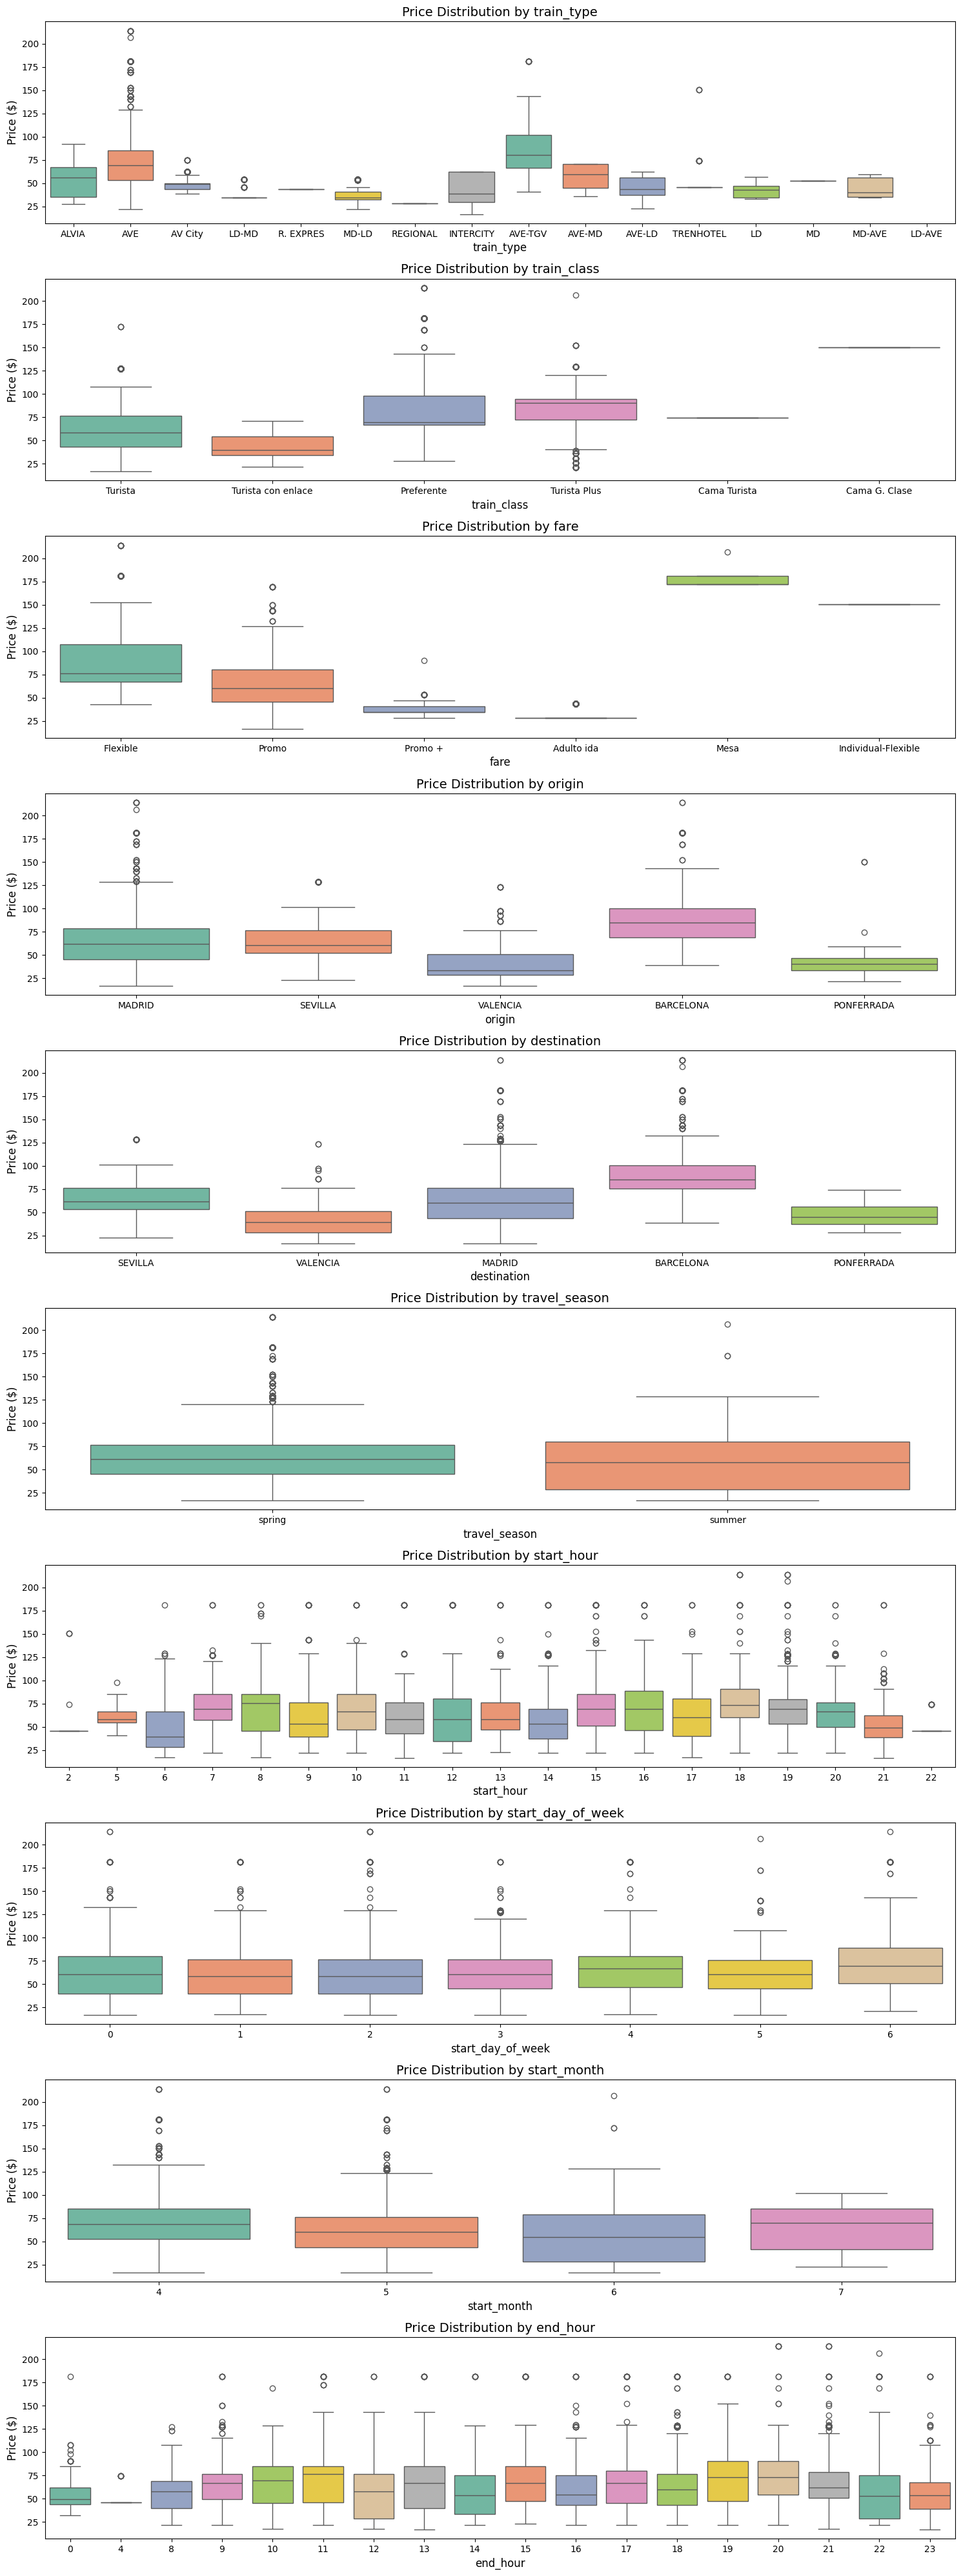

In [35]:
# set figsize
plt.figure(figsize=(15, 4 * len(features)))

# loop through features
for i, col in enumerate(features, 1):
    plt.subplot(len(features), 1, i) # Create subplots
    sns.boxplot(x=df[col], y=df['price'], palette='Set2')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.title(f'Price Distribution by {col}', fontsize=14)

plt.tight_layout()
plt.show()

* Fare
    * Promo: Widest price range
    * Flexible: Has quite a few outliers has exceptionally high price
    * Other fare types fall around simliar price range.
* Train Class
    * Turista con enlace: has the lowest median price.
* Train Type: Though prices range vary by train type, it's around $25-$125 price range.
* Origin & Destination: Departing from or to Barcelona has higher price.
* Season: Summer time has a wider spread of price than Spring.
* Traveling day of the week of the start date has not too much difference in price.

In [61]:
df.isnull().sum()/len(df)*100

insert_date             0.000000
origin                  0.000000
destination             0.000000
start_date              0.000000
end_date                0.000000
train_type              0.000000
price                  11.946663
train_class             0.399256
fare                    0.399256
duration                0.000000
duration_to_seconds     0.000000
travel_season           0.000000
start_hour              0.000000
start_day_of_week       0.000000
start_month             0.000000
end_hour                0.000000
dtype: float64

<Figure size 600x400 with 0 Axes>

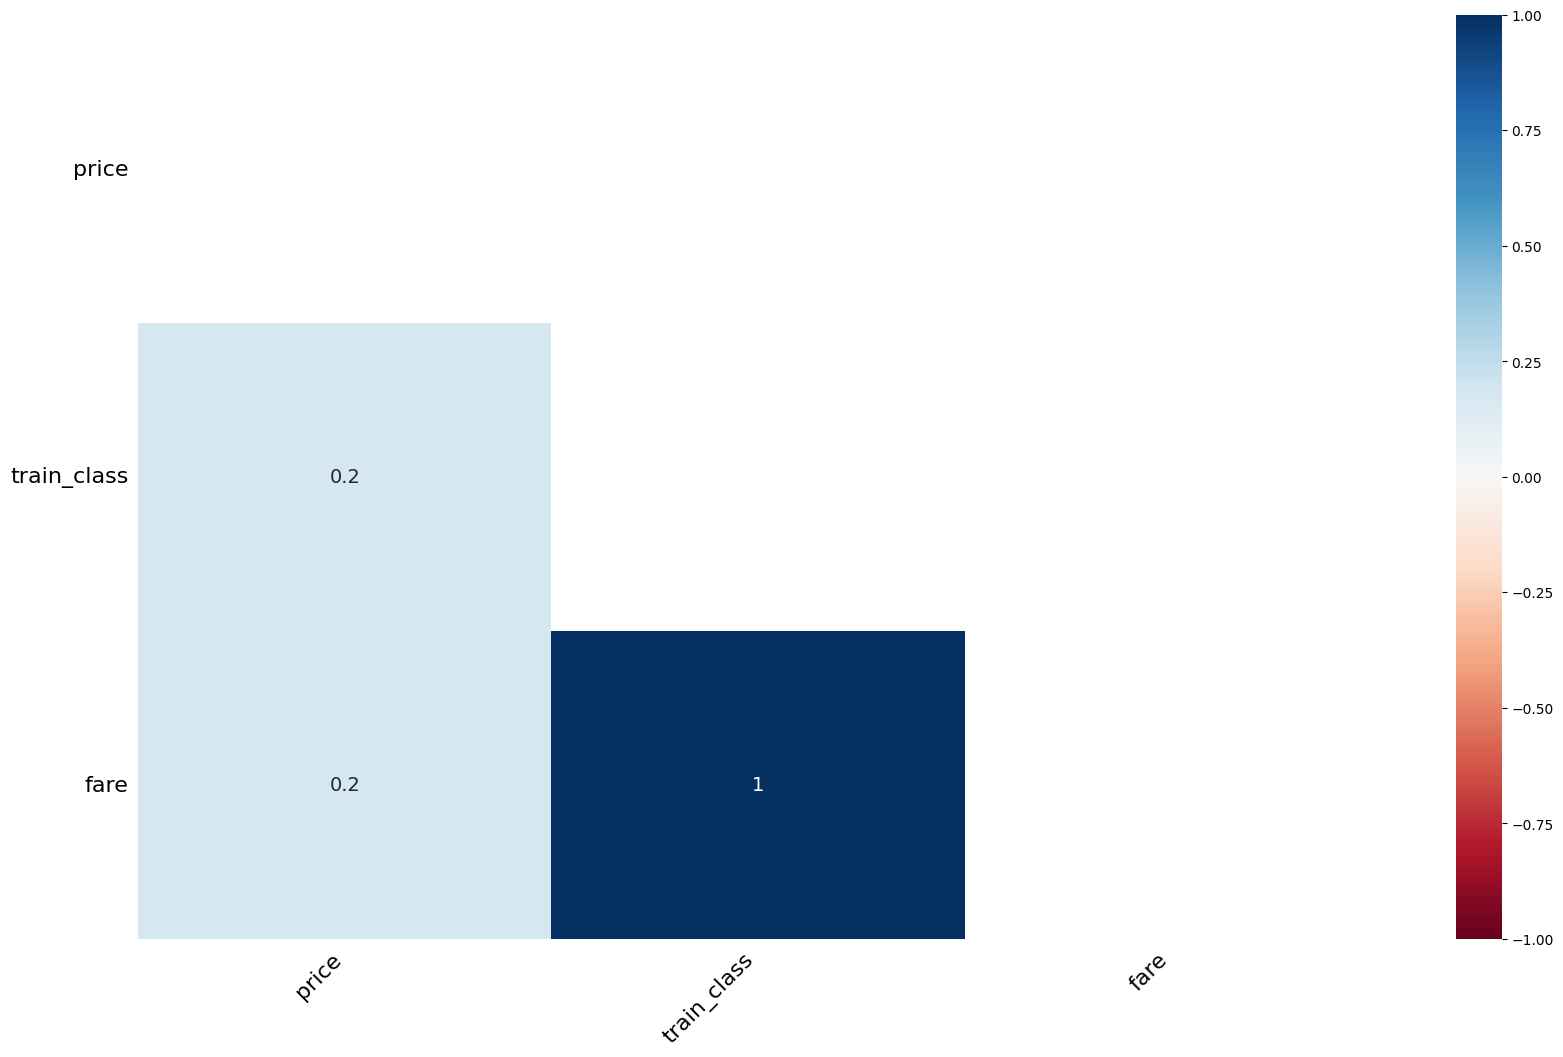

In [12]:
# import missingno as msno
plt.figure(figsize=(6,4))
msno.heatmap(df)
plt.show()

11% of price data is missing. Fare and train_class missingness is strongly related.
#### Fill the missing value:

In [9]:
print(df['train_class'].mode())
print(df['train_class'].unique())

0    Turista
Name: train_class, dtype: object
['Turista' 'Turista con enlace' 'Preferente' 'Turista Plus' nan
 'Cama Turista' 'Cama G. Clase']


In [11]:
# Simple imputation to those with low percentage of missing data
df['train_class'] = df['train_class'].fillna(df['train_class'].mode().iloc[0]) 
df['fare'] = df['fare'].fillna(df['fare'].mode().iloc[0]) 
# Group by fare type and imput the mean value of its type
# df['price'] = df.groupby('fare')['price'].transform(lambda x: x.fillna(x.mean()))

#### Label Encoding: Convert Categorical Features to Numeric
Bayesian models in PyMC3 (or any statistical models) in general requires numeric data, and reduce computataion complexity. 
* `astype('category').cat.codes` is reversible and easty to map back to original labels.
* May not be that suitable to use one-hot encoding that brings in a wide table.

In [12]:

mappings = {} # Dictionary to store mappings

for feature in features:
    df[feature] = df[feature].astype('category')
    # Store mapping
    # mapping[i] = dict(enumerate(df[i].cat.categories)) #this assign indexes as keys, but we need category name as keys
    mappings[feature] = {category: code for code, category in enumerate(df[feature].cat.categories)}
    # Convert to numeric
    df[feature] = df[feature].cat.codes 

In [13]:
mappings

{'train_type': {'ALVIA': 0,
  'AV City': 1,
  'AVE': 2,
  'AVE-LD': 3,
  'AVE-MD': 4,
  'AVE-TGV': 5,
  'INTERCITY': 6,
  'LD': 7,
  'LD-AVE': 8,
  'LD-MD': 9,
  'MD': 10,
  'MD-AVE': 11,
  'MD-LD': 12,
  'R. EXPRES': 13,
  'REGIONAL': 14,
  'TRENHOTEL': 15},
 'train_class': {'Cama G. Clase': 0,
  'Cama Turista': 1,
  'Preferente': 2,
  'Turista': 3,
  'Turista Plus': 4,
  'Turista con enlace': 5},
 'fare': {'Adulto ida': 0,
  'Flexible': 1,
  'Individual-Flexible': 2,
  'Mesa': 3,
  'Promo': 4,
  'Promo +': 5},
 'origin': {'BARCELONA': 0,
  'MADRID': 1,
  'PONFERRADA': 2,
  'SEVILLA': 3,
  'VALENCIA': 4},
 'destination': {'BARCELONA': 0,
  'MADRID': 1,
  'PONFERRADA': 2,
  'SEVILLA': 3,
  'VALENCIA': 4},
 'travel_season': {'spring': 0, 'summer': 1},
 'start_hour': {2: 0,
  5: 1,
  6: 2,
  7: 3,
  8: 4,
  9: 5,
  10: 6,
  11: 7,
  12: 8,
  13: 9,
  14: 10,
  15: 11,
  16: 12,
  17: 13,
  18: 14,
  19: 15,
  20: 16,
  21: 17,
  22: 18},
 'start_day_of_week': {0: 0, 1: 1, 2: 2, 3: 3, 4: 

In [19]:
# Debug 
print("Encoding Mappings:")
for feature, values in mappings.items():
    print(f"{feature}: {values}")

Encoding Mappings:
train_type: {'ALVIA': 0, 'AV City': 1, 'AVE': 2, 'AVE-LD': 3, 'AVE-MD': 4, 'AVE-TGV': 5, 'INTERCITY': 6, 'LD': 7, 'LD-AVE': 8, 'LD-MD': 9, 'MD': 10, 'MD-AVE': 11, 'MD-LD': 12, 'R. EXPRES': 13, 'REGIONAL': 14, 'TRENHOTEL': 15}
train_class: {'Cama G. Clase': 0, 'Cama Turista': 1, 'Preferente': 2, 'Turista': 3, 'Turista Plus': 4, 'Turista con enlace': 5}
fare: {'Adulto ida': 0, 'Flexible': 1, 'Individual-Flexible': 2, 'Mesa': 3, 'Promo': 4, 'Promo +': 5}
origin: {'BARCELONA': 0, 'MADRID': 1, 'PONFERRADA': 2, 'SEVILLA': 3, 'VALENCIA': 4}
destination: {'BARCELONA': 0, 'MADRID': 1, 'PONFERRADA': 2, 'SEVILLA': 3, 'VALENCIA': 4}
travel_season: {'spring': 0, 'summer': 1}
start_hour: {2: 0, 5: 1, 6: 2, 7: 3, 8: 4, 9: 5, 10: 6, 11: 7, 12: 8, 13: 9, 14: 10, 15: 11, 16: 12, 17: 13, 18: 14, 19: 15, 20: 16, 21: 17, 22: 18}
start_day_of_week: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
start_month: {4: 0, 5: 1, 6: 2, 7: 3}
end_hour: {0: 0, 4: 1, 8: 2, 9: 3, 10: 4, 11: 5, 12: 6, 13: 7

In [45]:
df.price.describe()

count    22716.000000
mean        63.444532
std         25.912413
min         16.600000
25%         43.662500
50%         60.300000
75%         78.800000
max        214.200000
Name: price, dtype: float64

Pairwise Feature Correlation (Spearman for Categorical):

In [17]:
df[['price', 'train_type', 'train_class', 'fare', 'origin', 'destination', 'travel_season', 'start_hour', 'start_day_of_week', 'start_month', 'end_hour']].corr(method='spearman')

price  train_type  train_class      fare    origin  \
price              1.000000   -0.347712    -0.103461 -0.065912 -0.469625   
train_type        -0.347712    1.000000     0.281869 -0.238619  0.052154   
train_class       -0.103461    0.281869     1.000000  0.066438 -0.058079   
fare              -0.065912   -0.238619     0.066438  1.000000 -0.084630   
origin            -0.469625    0.052154    -0.058079 -0.084630  1.000000   
destination       -0.479532    0.055316    -0.056597 -0.115886 -0.085213   
travel_season     -0.068064    0.124197    -0.021886 -0.076952 -0.022029   
start_hour         0.073924   -0.083982     0.006615  0.075608 -0.038336   
start_day_of_week  0.087166    0.004060    -0.023012 -0.058873  0.004835   
start_month       -0.125409    0.077919     0.027315  0.044612 -0.019999   
end_hour          -0.028399    0.167906     0.103935 -0.063611  0.031644   

                   destination  travel_season  start_hour  start_day_of_week  \
price                -0.479532      -0.068064    0.073924           0.087166   
train_type            0.055316       0.124197   -0.083982           0.004060   
train_class          -0.056597      -0.021886    0.006615          -0.023012   
fare                 -0.115886      -0.076952    0.075608          -0.058873   
origin               -0.085213      -0.022029   -0.038336           0.004835   
destination           1.000000      -0.018304    0.051125           0.012556   
travel_season        -0.018304       1.000000   -0.010461           0.158374   
start_hour            0.051125      -0.010461    1.000000           0.094168   
start_day_of_week     0.012556       0.158374    0.094168           1.000000   
start_month          -0.014349       0.631235   -0.015408           0.121824   
end_hour              0.027035       0.052987    0.833952           0.099798   

                   start_month  end_hour  
price                -0.125409 -0.028399  
train_type            0.077919  0.167906  
train_class           0.027315  0.103935  
fare                  0.044612 -0.063611  
origin               -0.019999  0.031644  
destination          -0.014349  0.027035  
travel_season         0.631235  0.052987  
start_hour           -0.015408  0.833952  
start_day_of_week     0.121824  0.099798  
start_month           1.000000  0.023934  
end_hour              0.023934  1.000000

* Fare, Train_type and Train_class, Origin, Destination, Travel_season, start_month and end_hour all have moderate median negative correlation with Price.
* start_hour and start_day_of_week are positive correlated with price.
* But overall the correlation is not strong.

#### KNN Imputer (k=5)
Doesn't rely on a strong linear relationship but fins similar pattern withing rows

In [15]:
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

target_col = 'price'
X = df.copy()
X_knn = X.copy()
X_knn[target_col] = knn_imputer.fit_transform(X[[target_col]])


In [19]:
X_knn.head()

insert_date  origin  destination          start_date  \
0  2019-04-22 08:00:25       1            3 2019-04-28 08:30:00   
1  2019-04-22 10:03:24       1            4 2019-05-20 06:45:00   
2  2019-04-25 19:19:46       1            3 2019-05-29 06:20:00   
3  2019-04-24 06:21:57       3            1 2019-05-03 08:35:00   
4  2019-04-19 21:13:55       4            1 2019-05-10 09:40:00   

             end_date  train_type      price  train_class  fare  \
0 2019-04-28 11:14:00           0  63.444532            3     1   
1 2019-05-20 08:38:00           2  21.950000            3     4   
2 2019-05-29 09:16:00           1  38.550000            3     4   
3 2019-05-03 15:26:00           9  34.350000            5     5   
4 2019-05-10 11:20:00           2  45.300000            3     4   

         duration  duration_to_seconds  travel_season  start_hour  \
0 0 days 02:44:00               9840.0              0           8   
1 0 days 01:53:00               6780.0              0           6   
2 0 days 02:56:00              10560.0              0           6   
3 0 days 06:51:00              24660.0              0           8   
4 0 days 01:40:00               6000.0              0           9   

   start_day_of_week  start_month  end_hour  
0                  6            4        11  
1                  0            5         8  
2                  2            5         9  
3                  4            5        15  
4                  4            5        11

## Step 3. Define & Train the Bayesian Model
Assume the ticket price will follow normal distribution, formed by linear regression with factors of independent variables with the same variance.

1. Prior Distribution: As **Bayesian Inference** is built on prior knowledge, could NOT use the **empirical mean and standard deviation** we found earlier but estimation

    * Assign priors to unkown parameters based on domain knowledge. For example: $α,β∼N(0,10)$
    * **$α$ is the base price**. I set the boundaries of price range between $10 and $300, with a standard deviation of $20.
    * **$β$ captures how features affect price**. (assumed normal prior at -2: demand decreases as price rises)

<br/>

2. Likelihood Function: 
    * The demand can be modeled as: $$Demand=α+β*Price+ϵ$$
    * where $ϵ∼N(0,σ^2)$ captures noise.

<br/>

3. Posterior Distribution:
    * Using `PyMC`, sample from the posterior to estimate price elasticity.
    * `PyMC` uses **NUTS (No-U-Turn Sample)**, and advanced for m of Hamiltonian Monte Carlo (HMC) that could avoid **_random walk behavior_** in simpler MCMC methods like Metropolis-Hastings by exploring the probability landscape efficiently. This leads to faster convergence and more accurate posterior estimation.


#### Train the model:
1. Use `Markove Chain Monte Carlo (MCMC)` sampling (eg. `NUTS sampler` in `PYMC`) to estimate the posterior distribution of base price, coefficient and noise.
* MCMC is used in Bayesian statistics to approximate the posterior distribution when direct computation is infeasible. It's to generate samples representing the distribution of our unknown parameters.
* Steps:
    - Start with an initial guess for $α, β, ϵ$
    - Iterate using a probability-based process: new values for parameters are proposed based on a probability distribution, then accept or reject the new values based on how well they fit the data
    - Convert to a stable distribution after many iterations, giving us the posterior.
2. Evaluate convergence using diagnostics like:
    * Trace plots
    * Autocorrelation plots
    * Gelman-Rubin statistic

In [21]:
X_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25798 entries, 0 to 25797
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   insert_date          25798 non-null  object         
 1   origin               25798 non-null  int8           
 2   destination          25798 non-null  int8           
 3   start_date           25798 non-null  datetime64[ns] 
 4   end_date             25798 non-null  datetime64[ns] 
 5   train_type           25798 non-null  int8           
 6   price                25798 non-null  float64        
 7   train_class          25798 non-null  int8           
 8   fare                 25798 non-null  int8           
 9   duration             25798 non-null  timedelta64[ns]
 10  duration_to_seconds  25798 non-null  float64        
 11  travel_season        25798 non-null  int8           
 12  start_hour           25798 non-null  int32          
 13  start_day_of_wee

In [20]:
X_knn.columns

Index(['insert_date', 'origin', 'destination', 'start_date', 'end_date',
       'train_type', 'price', 'train_class', 'fare', 'duration',
       'duration_to_seconds', 'travel_season', 'start_hour',
       'start_day_of_week', 'start_month', 'end_hour'],
      dtype='object')

In [16]:
dt = X_knn.copy()

In [17]:
dt = dt.drop(columns=['duration', 'insert_date', 'start_date', 'end_date'])
dt.head()

origin  destination  train_type      price  train_class  fare  \
0       1            3           0  63.444532            3     1   
1       1            4           2  21.950000            3     4   
2       1            3           1  38.550000            3     4   
3       3            1           9  34.350000            5     5   
4       4            1           2  45.300000            3     4   

   duration_to_seconds  travel_season  start_hour  start_day_of_week  \
0               9840.0              0           4                  6   
1               6780.0              0           2                  0   
2              10560.0              0           2                  2   
3              24660.0              0           4                  4   
4               6000.0              0           5                  4   

   start_month  end_hour  
0            0         5  
1            1         2  
2            1         3  
3            1         9  
4            1         5

Standardize continuous features for better sampling efficiency

In [18]:
dt['duration_std'] = (dt['duration_to_seconds'] - dt['duration_to_seconds'].mean()) / dt['duration_to_seconds'].std()

In [79]:
dt['duration_std'].describe()

count    2.579800e+04
mean    -1.162296e-16
std      1.000000e+00
min     -9.348629e-01
25%     -4.060013e-01
50%     -3.246380e-01
75%      8.152732e-04
max      5.645395e+00
Name: duration_std, dtype: float64

In [25]:
dt.columns

Index(['origin', 'destination', 'train_type', 'price', 'train_class', 'fare',
       'duration_to_seconds', 'travel_season', 'start_hour',
       'start_day_of_week', 'start_month', 'end_hour'],
      dtype='object')

#### Build the Bayesian Model:
* Optimize model training with vectorized operations instead of loops

In [20]:
# Convert categorical features to NumPy array for faster computation
fare_array = dt['fare'].to_numpy()
class_array = dt['train_class'].to_numpy()
train_array = dt['train_type'].to_numpy()
og_array = dt['origin'].to_numpy()
dest_array = dt['destination'].to_numpy()
season_array = dt['travel_season'].to_numpy()
sthr_array = dt['start_hour'].to_numpy()
wd_array = dt['start_day_of_week'].to_numpy()
m_array = dt['start_month'].to_numpy()
edhr_array = dt['end_hour'].to_numpy()

In [33]:
# Define Bayesian Regression Model using PyMC3
with pm.Model() as bayesian_model:
    # Step 1. Prioir belief for the coefficients
    # Baseline price: the expected deman when tieck price is at $0 (assumed following a normal distribution at 100 and uncertainty (sigma=20))
    alpha = pm.Normal('alpha', mu=100, sigma=50)#df['price'].mean(), sigma=df['price'].std()) # Baseline price
    
    # Price sensitivity by fare type
    beta_fare = pm.Normal('beta_fare', mu=0, sigma=2) # Fare type effect
    beta_class = pm.Normal('beta_class', mu=0, sigma=2) # Train class effect
    beta_train = pm.Normal('beta_train', mu=0, sigma=3) # Train type effect
    beta_origin = pm.Normal('beta_origin', mu=0, sigma=2) 
    beta_destination = pm.Normal('beta_destination', mu=0, sigma=2)
    beta_duration = pm.Normal('beta_duration', mu=0, sigma=10)
    beta_travel_season = pm.Normal('beta_travel_season', mu=0, sigma=1)
    beta_start_hour = pm.Normal('beta_start_hour', mu=0, sigma=2)
    beta_start_day_of_week = pm.Normal('beta_start_day_of_week', mu=0, sigma=2)
    beta_start_month = pm.Normal('beta_start_month', mu=0, sigma=2)
    beta_end_hour = pm.Normal('beta_end_hour', mu=0, sigma=2)
    
    # Noise: uncertainty in demand due to external factors (HalfNormal distribution: only positive values)
    sigma = pm.HalfNormal('sigma', sigma=50) #sigma=df['price'].std()) 
    
    # Step 2. Define likihood function
    # Expected price equation (using vectorized calculation):
    price_mu = (
        alpha 
        + beta_fare * fare_array
        + beta_class * class_array
        + beta_train * train_array
        + beta_origin * og_array
        + beta_destination * dest_array
        + beta_duration * dt['duration_std'].to_numpy()
        + beta_travel_season * season_array
        + beta_start_hour * sthr_array
        + beta_start_day_of_week * wd_array
        + beta_start_month * m_array
        + beta_end_hour * edhr_array
    ) 
    
    # likelihood: assume observed demand follows a normal distribution around `price_mu` with uncertainty `sigma`
    price_obs = pm.Normal('price_obs', mu=price_mu, sigma=sigma, observed=dt['price'].to_numpy())
    
    # Sampling using MCMC to estimate the posterior distributions of `alpha`, `beta` and `sigma`
    # trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True) #2000 samples are drawn to approximate the true demand function

    

`pm.sample(draw, chains, tune, random_seed, target_accept)`

* `draw` (posterior samples): the number of samples to draw from the posterior distribution, default as 1,000 (after tuning, the next 1,000 samples are kept as posterior estimates)
    * high sample count `2000` brings more precision but longer training time
    * `1500-2000` is balanced (default in most Bayesian workflows)
    * `1000`: lower precision but quick
    * `3000+`: high precision

* `chains`: the number of independent Markov chains to run, default as 4
* `tune` (burn-in phase): the number of iterations to use for tuning the sampler (then are discarded), default as 1,000 -> **higher tune could help the model to converge**
* `random_seed`: random number generator
* r`eturn_inference=True`: converts results into an ArviZ `InferenceData` object, making it easier to analyze
* `targe_accept`: (typically between `0 and 1`, **higher value means higher acceptance rate**, and generally leads to better exploration of the posterior distribution): (default as `0.8`)
    * a parameter controlling the desired acceptance rate of the MCMC sampler used to draw samples from a Bayesian model
    * which specified **how often the sampler should accept proposed new values** during the sampling process
    * **Divergence** happen when the sampler struggles to find an optimal solution -> `target_accept=0.9` to avoid excessive step rejection, which could reduce training time by 10-30%
* `nuts_sampler="jitter+adapt_diag"`: No-U-Turn Sampler can be tuned for efficiency -> outdated


In [34]:
# multiprocessing in PyMC
with bayesian_model:
    trace = pm.sample(
        1000, 
        tune=1000, 
        # cores=mp.cpu_count(), 
        target_accept=0.9, 
        # sampler='pymc', 
        # initvals= {var: "jitter+adapt_diag" for var in bayesian_model.named_vars}, 
        return_inferencedata=True
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_fare, beta_class, beta_train, beta_origin, beta_destination, beta_duration, beta_travel_season, beta_start_hour, beta_start_day_of_week, beta_start_month, beta_end_hour, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 624 seconds.


* 4 chains: PyMC runs multiple independent MCMC chains (helps detect sampling issues)
* 1_000  tune sample per chain -> total of 4,000
* 1_000 draw per chain -> total of 4,000
* total computation time: 655 seconds (depend on model complexity and CPU/GPU speed)


**2000 draws**:
Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 1279 seconds.

<br>

**1500 draws**:
Sampling 8 chains for 1_000 tune and 1_500 draw iterations (8_000 + 12_000 draws total) took 1364 seconds.

#### Feature Importance (Using Bayesian Coefficients)

drop low-impact variables before running expensive computations

In [35]:
# Extract posterior means for feature importance
posterior_mean = {
    key: np.mean(trace.posterior[key].values.flatten()) for key in trace.posterior.keys() if 'beta' in key
} 

# Convert to a sorted DataFrame
importance_df = pd.DataFrame(posterior_mean.items(), columns=['Feature', 'Coefficient'])
importance_df['Abs_Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values('Abs_Coefficient', ascending=False)

# Display top features
display(importance_df.head(10))



Feature  Coefficient  Abs_Coefficient
3              beta_origin    -9.972873         9.972873
4         beta_destination    -9.591905         9.591905
0                beta_fare    -5.614085         5.614085
9         beta_start_month    -4.683413         4.683413
5            beta_duration    -4.381481         4.381481
1               beta_class    -2.844355         2.844355
2               beta_train    -1.859756         1.859756
6       beta_travel_season     1.676621         1.676621
8   beta_start_day_of_week     0.867391         0.867391
10           beta_end_hour     0.495381         0.495381

* We will select only the top 5 important features to save computing time for final price optimization

#### Model Diagnostics: Check Posterior Distributions

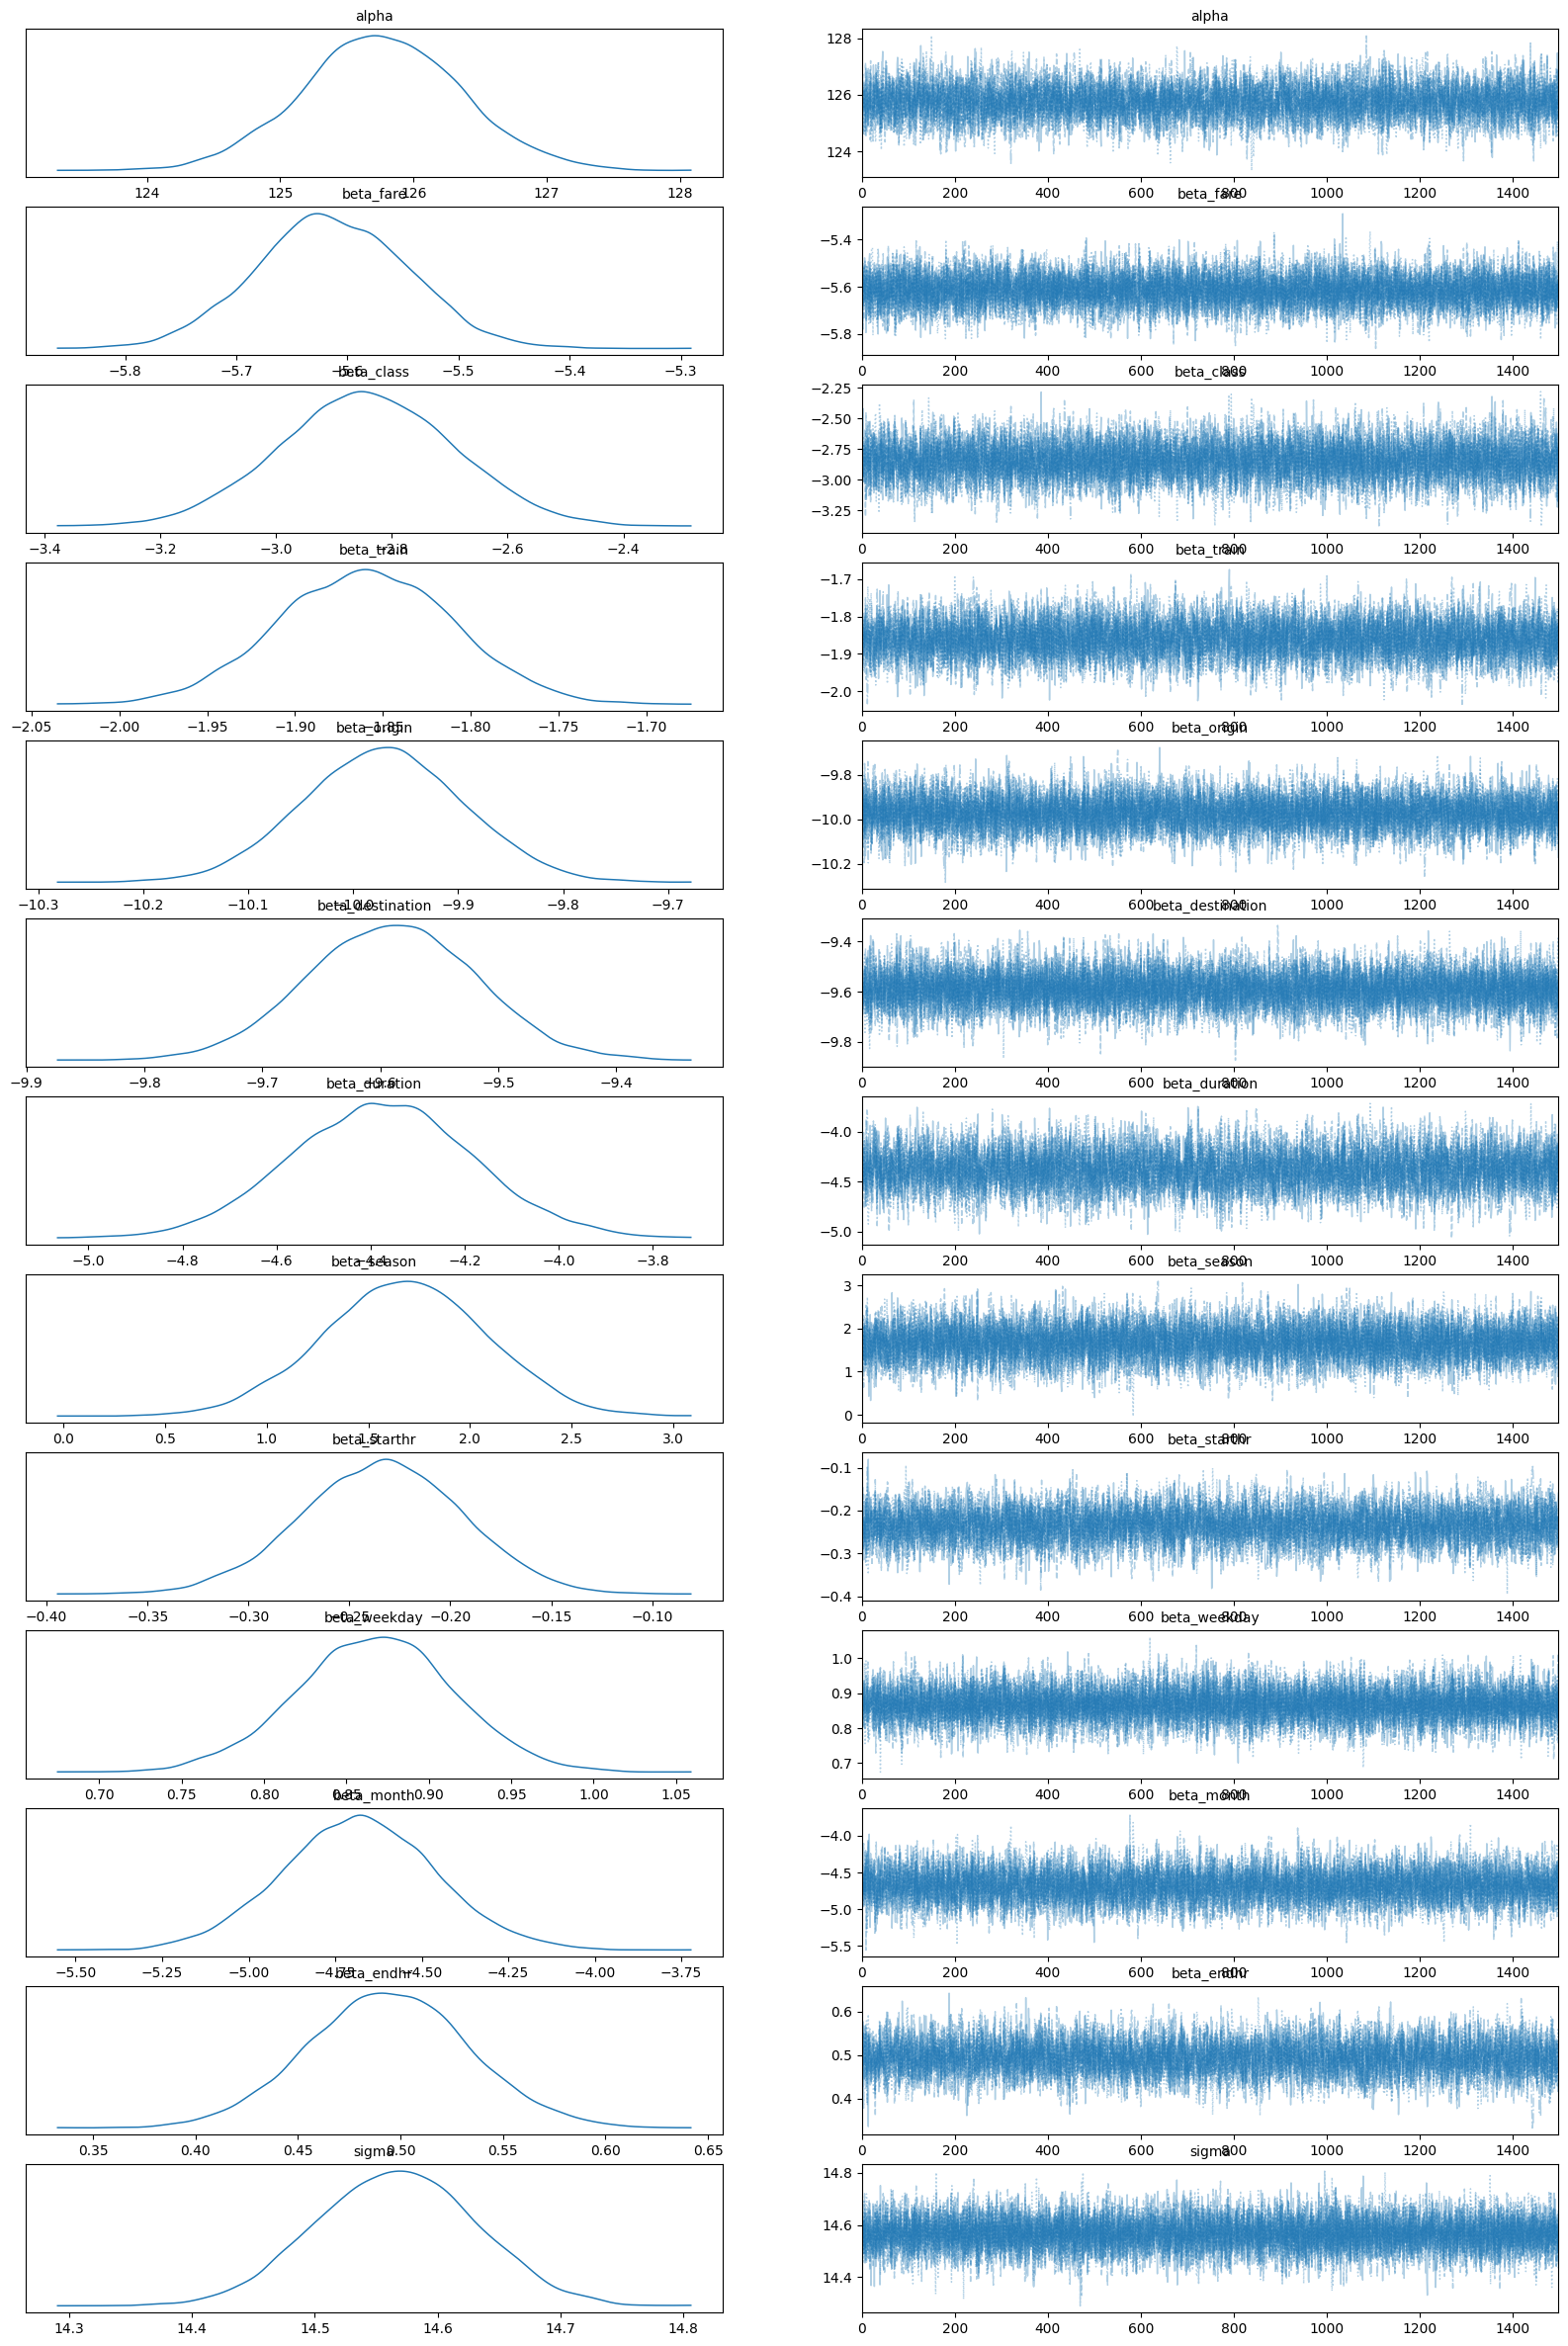

In [32]:
az.plot_trace(trace, figsize=(20,30), combined=True) # larger plots combine chains
# Adjust font size
plt.rcParams.update({'axes.labelsize': 12, 'axes.titlesize':14})
plt.show()

* Right-side: `MCMC Chain Plot for convergence`: shown as a hairy caterpillar without big jumps, meaning good mixing. -> It seems that individual parameters converged and stationary
    * (if long streaks of similar values; drifting chains -> the model has convergence issues)
* Left-side: `Posterior Distribution Plot`: Show the estimated distribution of each parameter; peak represents the most probable value for that parameter. 
    * wider distributions mean more uncertainty, and it means that the model needs more data or better priors.
    * The current plot looks smooth and unmodel distributions

#### Interpret the Posterior Distributions:

In [33]:
az.summary(trace)

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha             125.759  0.599  124.618  126.885      0.007    0.005   
beta_fare          -5.615  0.068   -5.747   -5.492      0.001    0.000   
beta_class         -2.843  0.152   -3.136   -2.569      0.002    0.001   
beta_train         -1.860  0.050   -1.954   -1.770      0.001    0.000   
beta_origin        -9.972  0.077  -10.117   -9.832      0.001    0.001   
beta_destination   -9.590  0.071   -9.726   -9.460      0.001    0.000   
beta_duration      -4.377  0.195   -4.733   -3.999      0.002    0.002   
beta_season         1.678  0.402    0.927    2.428      0.004    0.003   
beta_starthr       -0.234  0.040   -0.311   -0.161      0.000    0.000   
beta_weekday        0.867  0.047    0.776    0.956      0.000    0.000   
beta_month         -4.681  0.222   -5.095   -4.261      0.002    0.002   
beta_endhr          0.494  0.039    0.422    0.570      0.000    0.000   
sigma              14.566  0.065   14.444   14.686      0.001    0.000   

                  ess_bulk  ess_tail  r_hat  
alpha               7210.0    7535.0    1.0  
beta_fare          11987.0    8953.0    1.0  
beta_class          9168.0    8351.0    1.0  
beta_train          7823.0    8626.0    1.0  
beta_origin        10878.0    8818.0    1.0  
beta_destination   11366.0    8843.0    1.0  
beta_duration       6492.0    7863.0    1.0  
beta_season         9610.0    9708.0    1.0  
beta_starthr        7044.0    7652.0    1.0  
beta_weekday       13910.0    9043.0    1.0  
beta_month          8337.0    9263.0    1.0  
beta_endhr          6767.0    7800.0    1.0  
sigma              15572.0    8213.0    1.0

* Mean: showing how feature impacts price
    * alpha: base price as 125
    * besides `beta_season`, `beta_weekday`, `beta_endhr` showing positive impact to price, others have negative.
* 95% credible inverval: the uncertainty range for each estimate
* `r^`: should be close to  1 (ensures the chaings have converged)
    * If R-hat is about 1, Chains have converged.
    * If R-hat > 1.1, Chains didn't mix well, increse `tune` or improve priors.


#### Bayesian Analysis: How features impact price
Posterior distributions with summary statistics

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta_fare'}>,
        <Axes: title={'center': 'beta_class'}>,
        <Axes: title={'center': 'beta_train'}>],
       [<Axes: title={'center': 'beta_origin'}>,
        <Axes: title={'center': 'beta_destination'}>,
        <Axes: title={'center': 'beta_duration'}>,
        <Axes: title={'center': 'beta_season'}>],
       [<Axes: title={'center': 'beta_starthr'}>,
        <Axes: title={'center': 'beta_weekday'}>,
        <Axes: title={'center': 'beta_month'}>,
        <Axes: title={'center': 'beta_endhr'}>],
       [<Axes: title={'center': 'sigma'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

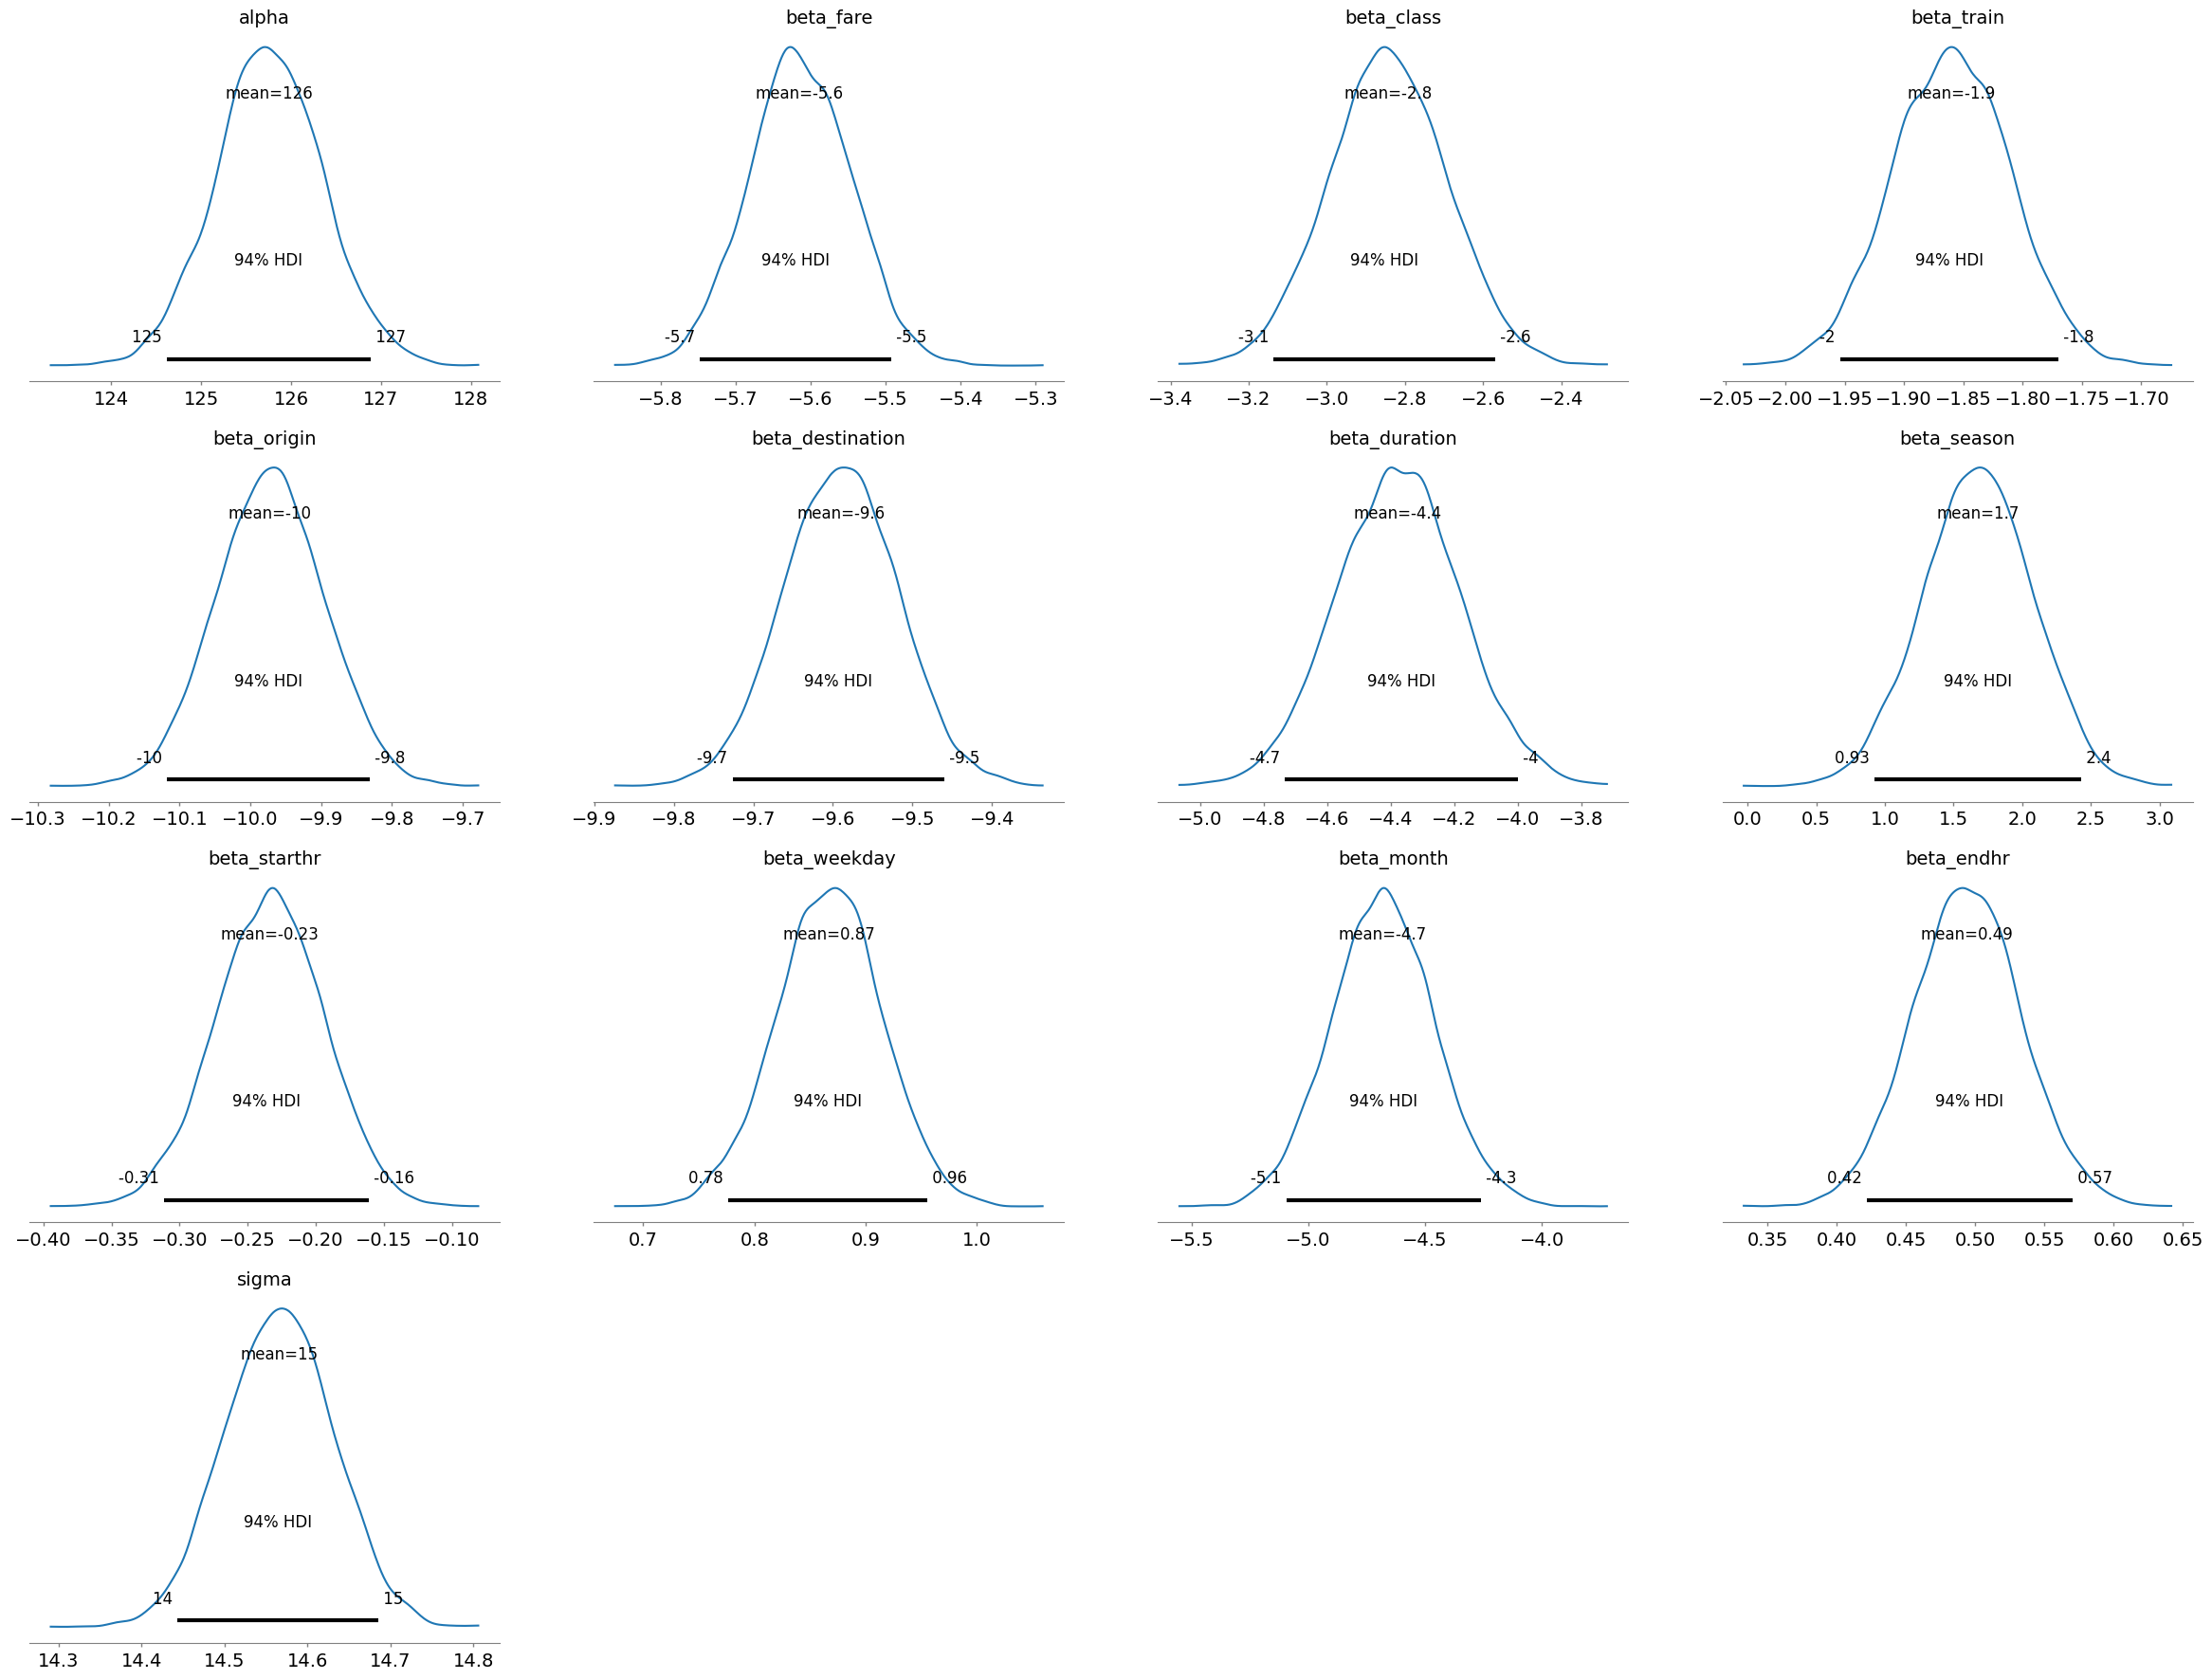

In [34]:
az.plot_posterior(trace)

* `alpha=126`: as the baseline price, 94% of Highest Density Interval (HDI) is [125, 127], meaning we are quite confident that the true value is in this range.
* `beta_fare=-5.6`: fare type significantly reduces price; HDI of [-5.7, -5.5] means strong confidence.
* `beta_class=-2.8`, `beta_train=-1.9`, `beta_origin=-1.0` etc.
* `beta_starthr=-0.23` quite close to 0, meaning that start hour has little effect on price.

## 5. Interpret and Use the Model for Price Optimization
1. Estiamte Price Elasticity:
    * The posterior estimates for $β$ tell us how much price changes when features changes.
    * If $β < 0$, price decreases with positive features change.

<br/>

2. Find Optimal Price for Maximum Revenue:
    * Compute expected revenue for different prices: $$E[Revenue]= Price * E[Demand | Price]$$
    * Identify the price where revenue is maximized.

<br/>

3. Uncertainty Quantification:
    * Use credible intervals to estimate confidence in pricing decisions.


#### Define revenue results with features combo:
* vectorize expected price calculation: precompute feature combo as NumPy arrays
* Compute revenue results in parallel with multiprocessing

In [36]:
# select top 5 features
selected_features = importance_df['Feature'].head(5).tolist()

In [37]:
# Extract posterior means for all features
# posterior_mean = {key: np.mean(trace.posterior[key].value.flatten()) for key in trace.posterior.keys() if 'beta' in key}

# Add alphs to the selected features
selected_features.append('alpha')

In [38]:
selected_features

['beta_origin',
 'beta_destination',
 'beta_fare',
 'beta_start_month',
 'beta_duration',
 'alpha']

#### Generate Feature Combinations

In [39]:
# if mappings:
#     for feature, mapping in mappings.items():
#         print(f"{feature}: {mapping}")
# else:
#     print("mapping is empty")

# Debug ensure selected_features match mappings.keys()
print("Top Features:", selected_features)
print("Available Mappings:", mappings.keys())

# Find missing features
missing_features = [feature for feature in selected_features if feature not in mappings]
if missing_features:
    print("Error: the following features are in 'selected_features' but missing in 'mappings':", missing_features)

Top Features: ['beta_origin', 'beta_destination', 'beta_fare', 'beta_start_month', 'beta_duration', 'alpha']
Available Mappings: dict_keys(['train_type', 'train_class', 'fare', 'origin', 'destination', 'travel_season', 'start_hour', 'start_day_of_week', 'start_month', 'end_hour'])
Error: the following features are in 'selected_features' but missing in 'mappings': ['beta_origin', 'beta_destination', 'beta_fare', 'beta_start_month', 'beta_duration', 'alpha']


Since Bayesian features have "beta_" prefix, we need to strip the prefix before using them in mappings

In [80]:
top_features_original = [feature.replace('beta_', '') for feature in selected_features]
 
print("Top Features:", top_features_original)
print("Available Mappings:", mappings.keys())

Top Features: ['origin', 'destination', 'fare', 'start_month', 'duration', 'alpha']
Available Mappings: dict_keys(['train_type', 'train_class', 'fare', 'origin', 'destination', 'travel_season', 'start_hour', 'start_day_of_week', 'start_month', 'end_hour'])


In [81]:
# Define mappings for selected categorical features
feature_mappings = {
    feature: list(mappings[feature].values()) for feature in top_features_original if feature in mappings
}

print(feature_mappings)


# Ensure mappings contain values
print("Feature Mappings before Generating Combination:")
for feature, values in feature_mappings.items():
    print(f'{feature}: {values} (Length: {len(values)})')

{'origin': [0, 1, 2, 3, 4], 'destination': [0, 1, 2, 3, 4], 'fare': [0, 1, 2, 3, 4, 5], 'start_month': [0, 1, 2, 3]}
Feature Mappings before Generating Combination:
origin: [0, 1, 2, 3, 4] (Length: 5)
destination: [0, 1, 2, 3, 4] (Length: 5)
fare: [0, 1, 2, 3, 4, 5] (Length: 6)
start_month: [0, 1, 2, 3] (Length: 4)


In [82]:
# Generate all combo fo the selected features
feature_combos = list(itertools.product(*feature_mappings.values()))

# Convert to NumPy array for performance
feature_combos = np.array(feature_combos) if feature_combos else np.array([])
print(f"Generated {len(feature_combos)} feature combo.")

Generated 600 feature combo.


In [83]:
posterior_mean

{'beta_fare': -5.614084827132517,
 'beta_class': -2.84435474488239,
 'beta_train': -1.8597558855190377,
 'beta_origin': -9.972872554881102,
 'beta_destination': -9.591904980312176,
 'beta_duration': -4.381481225118059,
 'beta_travel_season': 1.6766212658303161,
 'beta_start_hour': -0.23573095807252487,
 'beta_start_day_of_week': 0.8673911684761294,
 'beta_start_month': -4.683413131682676,
 'beta_end_hour': 0.4953814821166893,
 'alpha': 126}

In [84]:
top_features_original

['origin', 'destination', 'fare', 'start_month', 'duration', 'alpha']

In [51]:
# Debug to ensure all feautres exist
print(posterior_mean.keys)

missing_features = [feature for feature in top_features_original if feature not in posterior_mean]
if missing_features:
    print("Error: the following features are missing in posterior_mean:", missing_features)

<built-in method keys of dict object at 0x16d049900>
Error: the following features are missing in posterior_mean: ['origin', 'destination', 'fare', 'start_month', 'duration', 'alpha']


Add a default `alpha` if it's missing:

In [60]:
if 'alpha' not in posterior_mean:
    posterior_mean['alpha'] = 126 ##np.mean(list(posterior_means.values()))

Rename `posterior_keys` to match `top_features_original`:

In [85]:
posterior_mean_rename = {
    key.replace('beta_', ''): np.mean(value) if isinstance(value, (list, np.ndarray)) else value
    for key, value in posterior_mean.items()
}
# posterior_mean_rename = [feature.replace('beta_', '') for feature in posterior_mean] #this return list

missing_features = [feature for feature in top_features_original if feature not in posterior_mean_rename]
if missing_features:
    print("Error: the following features are missing in posterior_mean_rename:", missing_features)

In [86]:
type(posterior_mean)

dict

In [87]:
type(posterior_mean_rename)

dict

In [88]:
# Debugging
print(feature_combos.shape)
print(len(feature_combos))
print(feature_combos[:5])# if len (feature_combo) > 0 else "None")
# print(feature_combos)
print('----')
print(top_features_original)
print(len(top_features_original))
if feature_combos.shape[1] != len(top_features_original):
    print("Error: 'feature_combos` doesn't match `top_feature_original`")
    top_features_original = top_features_original[:feature_combos.shape[1]]

(600, 4)
600
[[0 0 0 0]
 [0 0 0 1]
 [0 0 0 2]
 [0 0 0 3]
 [0 0 1 0]]
----
['origin', 'destination', 'fare', 'start_month', 'duration', 'alpha']
6
Error: 'feature_combos` doesn't match `top_feature_original`


In [89]:
top_features_original

['origin', 'destination', 'fare', 'start_month']

In [ ]:
# drop duration and alpha
# top_features_original = [f for f in top_features_original if f not in ['alpha', 'duration']]

In [98]:
# Define
def compute_revenue(category_tuple):
    """Computes expected revenue for a given combo of categorical variables with vectoried price computation for efficiency

    Args:
        category_tuple (_type_): _description_
    """
    if len(category_tuple) != len(top_features_original):
        print(f"Skipping invalid feature combo: {category_tuple} (Expected {len(top_features_original)} values, got {len(category_tuple)})")
        return None

    # Convert category_tuple into hashable type (NumPy arrays are not hashable)
    category_tuple = tuple(map(int, category_tuple))
    
    # Extract feature values from input tuple
    feature_values = {feature: category_tuple[idx] for idx, feature in enumerate(top_features_original) if feature != 'alpha'}
    # print(f"Processing Category: {category_tuple}") #Debugging print
    # fare_code, class_code, train_code, og, dest, season, starthr, weekday, month, endhr = category_tuple
    
    # Compute expected price (Bayesain linear model) #expected_demand is a scalar (single expected demand value)
    expected_price = int(posterior_mean_rename.get('alpha', 126)) 
    expected_price += posterior_mean_rename.get('duration', 0) * dt['duration_std'].median()
    
    for feature, value in feature_values.items():
        if feature in posterior_mean_rename:
            expected_price += posterior_mean_rename[feature] * value
        else:
            print(f"Warning: {feature} not found in `posterior_means_rename`")
    
    # Assume demand follows exponential decay with price
    expected_demand = np.exp(expected_price)
    
    # Price range to evaluate revenue curves
    price_range = np.linspace(10, 300, 50) #vector (array of prices)
    
    # compute expected revenue
    expected_revenue = price_range * expected_demand
    
    # print(f"Computed revenue for {category_tuple}: {expected_revenue[:5]}") #debugging print
    
    return category_tuple, expected_revenue

In [91]:
list(posterior_mean_rename.keys())

['fare',
 'class',
 'train',
 'origin',
 'destination',
 'duration',
 'travel_season',
 'start_hour',
 'start_day_of_week',
 'start_month',
 'end_hour',
 'alpha']

In [92]:
top_features_original

['origin', 'destination', 'fare', 'start_month']

In [93]:
feature_combos.shape

(600, 4)

In [99]:
if not isinstance(category_tuple, tuple):
    print(f"Error: `category_tupe` not a tuple. Converting now")
    category_tuple = tuple(map(int, category_tuple))

Error: `category_tupe` not a tuple. Converting now


In [100]:
# testing
test_tuple = feature_combos[0]
test_result = compute_revenue(test_tuple)
print(test_result)

((0, 0, 0, 0), array([2.18194170e+56, 3.47329495e+56, 4.76464821e+56, 6.05600146e+56,
       7.34735471e+56, 8.63870796e+56, 9.93006122e+56, 1.12214145e+57,
       1.25127677e+57, 1.38041210e+57, 1.50954742e+57, 1.63868275e+57,
       1.76781807e+57, 1.89695340e+57, 2.02608872e+57, 2.15522405e+57,
       2.28435937e+57, 2.41349470e+57, 2.54263002e+57, 2.67176535e+57,
       2.80090068e+57, 2.93003600e+57, 3.05917133e+57, 3.18830665e+57,
       3.31744198e+57, 3.44657730e+57, 3.57571263e+57, 3.70484795e+57,
       3.83398328e+57, 3.96311860e+57, 4.09225393e+57, 4.22138925e+57,
       4.35052458e+57, 4.47965990e+57, 4.60879523e+57, 4.73793055e+57,
       4.86706588e+57, 4.99620120e+57, 5.12533653e+57, 5.25447185e+57,
       5.38360718e+57, 5.51274251e+57, 5.64187783e+57, 5.77101316e+57,
       5.90014848e+57, 6.02928381e+57, 6.15841913e+57, 6.28755446e+57,
       6.41668978e+57, 6.54582511e+57]))


Parallel Processing to distribute workload across multiple CPU cores that could significantly reduces runtime:
* Use `concurrent.futures` 

In [32]:
mp.cpu_count()

8

In [101]:
import concurrent.futures

# Number of parallel threads (limit to 4 to avoid system overload)
num_threads = min(4, len(feature_combos))

# Dictionary to store results
revenue_results = {}

# Parallel execution
with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    future_to_categoy = {executor.submit(compute_revenue, category): category for category in feature_combos}
    
    for future in concurrent.futures.as_completed(future_to_categoy):
        result = future.result()
        if result: # Store only valid results
            category_tuple, expected_revenue = result
            revenue_results[category_tuple] = expected_revenue

# Print first few results
if revenue_results:
    print(f"First 3 results: {list(revenue_results.items())[:3]}")
else:
    print("Error: `revenue_results` is empty")
        

First 3 results: [((0, 0, 0, 2), array([1.86587344e+52, 2.97016589e+52, 4.07445834e+52, 5.17875078e+52,
       6.28304323e+52, 7.38733568e+52, 8.49162812e+52, 9.59592057e+52,
       1.07002130e+53, 1.18045055e+53, 1.29087979e+53, 1.40130904e+53,
       1.51173828e+53, 1.62216752e+53, 1.73259677e+53, 1.84302601e+53,
       1.95345526e+53, 2.06388450e+53, 2.17431375e+53, 2.28474299e+53,
       2.39517224e+53, 2.50560148e+53, 2.61603073e+53, 2.72645997e+53,
       2.83688922e+53, 2.94731846e+53, 3.05774771e+53, 3.16817695e+53,
       3.27860619e+53, 3.38903544e+53, 3.49946468e+53, 3.60989393e+53,
       3.72032317e+53, 3.83075242e+53, 3.94118166e+53, 4.05161091e+53,
       4.16204015e+53, 4.27246940e+53, 4.38289864e+53, 4.49332789e+53,
       4.60375713e+53, 4.71418638e+53, 4.82461562e+53, 4.93504486e+53,
       5.04547411e+53, 5.15590335e+53, 5.26633260e+53, 5.37676184e+53,
       5.48719109e+53, 5.59762033e+53])), ((0, 0, 0, 3), array([1.72544732e+50, 2.74663043e+50, 3.76781353e+50, 4.7

In [39]:
# # Number of CPU cores to use (avoid using all cores to keep system responsive)
# num_processes = min(4, mp.cpu_count())

# # Parallel processing with dynamically allocated CPU cores
# if __name__ == "main":
#     # Create a pool of worker processes (number of CPU cores used)
#     with mp.Pool(processes=num_processes) as pool:
#         # Distribute the function compute_revenue across multiple processes
#         results = pool.map(compute_revenue, feature_combos) # return a list of tuples (key-value)
    
#     # Store results while filtering out None or empty values
#     # revenue_results = {key: value for key, value in results if value is not None}
#     # Convert results to dictionary (more efficient key-based lookups)
#     revenue_results = dict(results)
    

#### Reverse Mappings

In [105]:
#reverse mapping creation: faster decoding
# Define reverse_mappings
reverse_mappings = {
    feature: {v: k for k, v in mappings[feature].items()} # Reverse dictionary
    for feature in mappings.keys()
}
# debug: print reverse mappings
print("Reverse mappings:")
for key, mapping in reverse_mappings.items():
    print(f"{key}: {mapping}")

Reverse mappings:
train_type: {0: 'ALVIA', 1: 'AV City', 2: 'AVE', 3: 'AVE-LD', 4: 'AVE-MD', 5: 'AVE-TGV', 6: 'INTERCITY', 7: 'LD', 8: 'LD-AVE', 9: 'LD-MD', 10: 'MD', 11: 'MD-AVE', 12: 'MD-LD', 13: 'R. EXPRES', 14: 'REGIONAL', 15: 'TRENHOTEL'}
train_class: {0: 'Cama G. Clase', 1: 'Cama Turista', 2: 'Preferente', 3: 'Turista', 4: 'Turista Plus', 5: 'Turista con enlace'}
fare: {0: 'Adulto ida', 1: 'Flexible', 2: 'Individual-Flexible', 3: 'Mesa', 4: 'Promo', 5: 'Promo +'}
origin: {0: 'BARCELONA', 1: 'MADRID', 2: 'PONFERRADA', 3: 'SEVILLA', 4: 'VALENCIA'}
destination: {0: 'BARCELONA', 1: 'MADRID', 2: 'PONFERRADA', 3: 'SEVILLA', 4: 'VALENCIA'}
travel_season: {0: 'spring', 1: 'summer'}
start_hour: {0: 2, 1: 5, 2: 6, 3: 7, 4: 8, 5: 9, 6: 10, 7: 11, 8: 12, 9: 13, 10: 14, 11: 15, 12: 16, 13: 17, 14: 18, 15: 19, 16: 20, 17: 21, 18: 22}
start_day_of_week: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
start_month: {0: 4, 1: 5, 2: 6, 3: 7}
end_hour: {0: 0, 1: 4, 2: 8, 3: 9, 4: 10, 5: 11, 6: 12, 7: 13,

In [106]:
{k: list(v.items())[:3] for k, v in reverse_mappings.items()} #show first 3 values

{'train_type': [(0, 'ALVIA'), (1, 'AV City'), (2, 'AVE')],
 'train_class': [(0, 'Cama G. Clase'), (1, 'Cama Turista'), (2, 'Preferente')],
 'fare': [(0, 'Adulto ida'), (1, 'Flexible'), (2, 'Individual-Flexible')],
 'origin': [(0, 'BARCELONA'), (1, 'MADRID'), (2, 'PONFERRADA')],
 'destination': [(0, 'BARCELONA'), (1, 'MADRID'), (2, 'PONFERRADA')],
 'travel_season': [(0, 'spring'), (1, 'summer')],
 'start_hour': [(0, 2), (1, 5), (2, 6)],
 'start_day_of_week': [(0, 0), (1, 1), (2, 2)],
 'start_month': [(0, 4), (1, 5), (2, 6)],
 'end_hour': [(0, 0), (1, 4), (2, 8)]}

Use on-the-fly reverse encoding so that we:
1. save computation time, as only selected features in `revenue_results` will be decoded
2. if a category was missing in `mappings`, using `.get(encoded_valaue, f"Unknown{encoded_value}")` prevent KeyErrors
3. ensure flexibility so that we ensure more flexibility if features were added or removed in the future.

In [107]:
def reverse_encode(feature_name, encoded_value):
    # Ensure reverse_mappings exists and contains the feature
    if feature_name not in reverse_mappings:
        print(f"Warning: Reverse mapping for {feature_name} not found. Check `mappings` definition.")
        return f"Unknown {encoded_value}"
    return reverse_mappings[feature_name].get(encoded_value, f"Unknown {encoded_value}")

# Debug: try reverse encoding
print("Testing Reverse Encoding:", reverse_encode('fare',1))


Testing Reverse Encoding: Flexible


#### Compute Optimal Prices with Reverse Decoding

In [109]:
top_features_original

['origin', 'destination', 'fare', 'start_month']

In [111]:
# Convert revenue_results into a structured DataFrame with readable labels
revenue_list = []

# Estimate demand as a function of price from the posterior samples (reshape to ensure broadcasting)
price_range = np.linspace(10, 300, 50)#.reshape(-1,1) # Prices range to evaluate #reshape to (50,1)

for category_tuple, revenue_array in revenue_results.items(): 
    # category_tuple must follows the correct order of top_features_original
    origin_label = reverse_encode('origin', category_tuple[0])
    destination_laebl = reverse_encode('destination', category_tuple[1])
    fare_label = reverse_encode('fare', category_tuple[2])
    month_label = reverse_encode('start_month', category_tuple[3])
    
    for price, revenue in zip(price_range, revenue_array):
        revenue_list.append([origin_label, destination_laebl, fare_label, month_label, price, revenue])

# Convert to df
revenue_df = pd.DataFrame(revenue_list, columns=["Origin", "Destination", "Fare Type", "Start Month", "Price", "Revenue"])

# Debugging
print(revenue_df.head())
    

      Origin Destination   Fare Type  Start Month      Price       Revenue
0  BARCELONA   BARCELONA  Adulto ida            6  10.000000  1.865873e+52
1  BARCELONA   BARCELONA  Adulto ida            6  15.918367  2.970166e+52
2  BARCELONA   BARCELONA  Adulto ida            6  21.836735  4.074458e+52
3  BARCELONA   BARCELONA  Adulto ida            6  27.755102  5.178751e+52
4  BARCELONA   BARCELONA  Adulto ida            6  33.673469  6.283043e+52


In [112]:
# Save the optimal price by categorical combo with expected revenue
# revenue_df.to_csv('optimal_price.csv',index=False)

#### Interactive UI to Adjust Key Variables
* Use `ipywidgets`
* Variables: "Origin", "Destination", "Fare Type", "Start Month"

In [113]:
pip install ipywidgets


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [114]:
import ipywidgets as widgets
from IPython.display import display

In [115]:
# Dropdowns for user input
origin_dropdown = widgets.Dropdown(
    options=revenue_df["Origin"].unique(), description="🚆 Origin:"
)
destination_dropdown = widgets.Dropdown(
    options=revenue_df["Destination"].unique(), description="🏁 Destination:"
)
fare_dropdown = widgets.Dropdown(
    options=revenue_df["Fare Type"].unique(), description="💰 Fare:"
)
month_dropdown = widgets.Dropdown(
    options=revenue_df["Start Month"].unique(), description="📅 Month:"
)

# Button to trigger optimal price calculation
button = widgets.Button(description="🔍 Find Optimal Price", button_style="primary")

# Output area for displaying the result
output = widgets.Output()

# Function to compute optimal price based on user selections
def find_optimal_price(b):
    with output:
        output.clear_output()  # Clear previous results
        
        # Filter DataFrame based on user selection
        filtered_df = revenue_df[
            (revenue_df["Origin"] == origin_dropdown.value) &
            (revenue_df["Destination"] == destination_dropdown.value) &
            (revenue_df["Fare Type"] == fare_dropdown.value) &
            (revenue_df["Start Month"] == month_dropdown.value)
        ]
        
        if not filtered_df.empty:
            optimal_price = filtered_df["Price"].iloc[filtered_df["Revenue"].idxmax()]
            print(f"🎯 The optimal ticket price for your selection is **${optimal_price:.2f}**")
            
            # Plot Revenue Curve
            plt.figure(figsize=(10, 5))
            sns.lineplot(data=filtered_df, x="Price", y="Revenue", label="Expected Revenue", color="blue")
            plt.axvline(optimal_price, color="red", linestyle="--", label=f"Optimal Price: ${optimal_price:.2f}")
            plt.xlabel("Ticket Price ($)")
            plt.ylabel("Expected Revenue ($)")
            plt.title("Revenue vs. Price Curve")
            plt.legend()
            plt.show()
        else:
            print("⚠️ No optimal price found for this selection. Try different options.")

# Attach event listener to button
button.on_click(find_optimal_price)

# Display widgets in Jupyter Notebook
display(origin_dropdown, destination_dropdown, fare_dropdown, month_dropdown, button, output)


Dropdown(description='🚆 Origin:', options=('BARCELONA', 'MADRID', 'PONFERRADA', 'SEVILLA', 'VALENCIA'), value=…

Dropdown(description='🏁 Destination:', options=('BARCELONA', 'MADRID', 'PONFERRADA', 'SEVILLA', 'VALENCIA'), v…

Dropdown(description='💰 Fare:', options=('Adulto ida', 'Flexible', 'Individual-Flexible', 'Mesa', 'Promo', 'Pr…

Dropdown(description='📅 Month:', options=(6, 7, 5, 4), value=6)

Button(button_style='primary', description='🔍 Find Optimal Price', style=ButtonStyle())

Output()

#### Pricing Optimization & Plotting

/var/folders/c7/zvfr__1n2v34xs_blw9dnt8h0000gn/T/ipykernel_8123/131906053.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  optimal_price = float(price_range[optimal_index])  # Convert to scalar


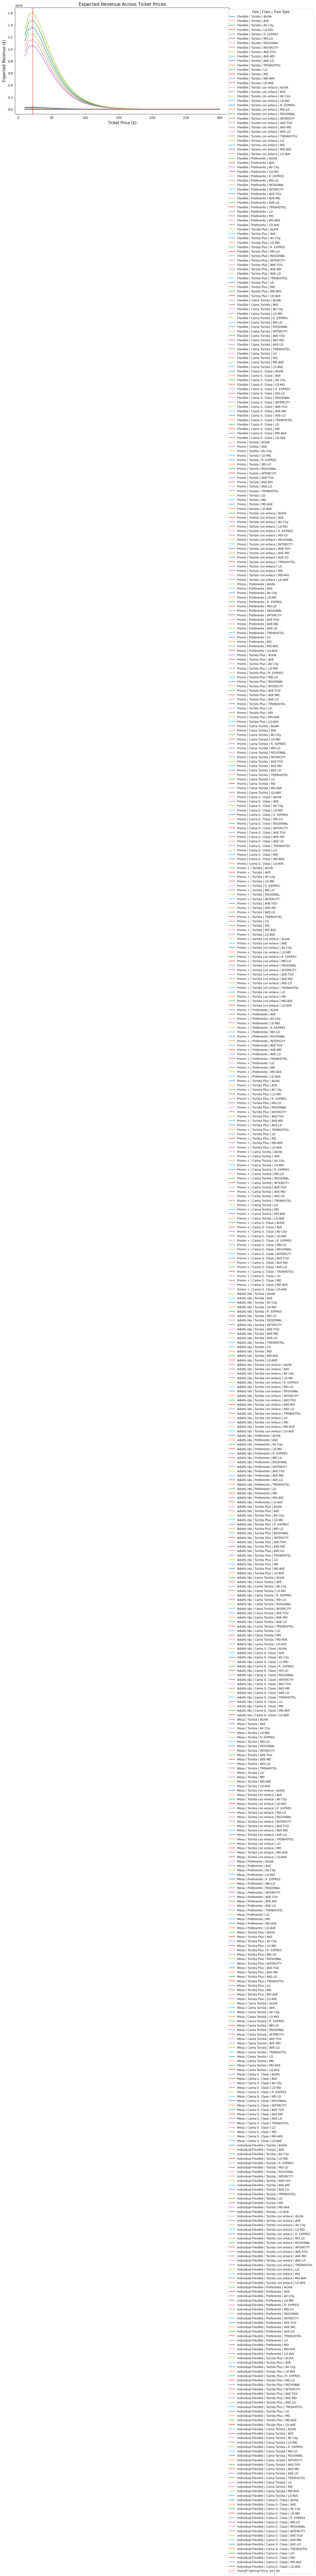

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure size
plt.figure(figsize=(12, 6))

optimal_prices_per_category = {}

# Plot revenue curves for each fare-class-train type combination
for category_tuple, revenue_curve in revenue_results.items():
    # Ensure category_tuple is valid
    if not isinstance(category_tuple, tuple) or len(category_tuple) != 3:
        print(f"Skipping invalid label: {category_tuple}")
        continue

    fare_code, class_code, train_code = category_tuple

    # Reverse encode category names
    fare_label = mapping["fare"].get(fare_code, f"Unknown {fare_code}")
    class_label = mapping["train_class"].get(class_code, f"Unknown {class_code}")
    train_label = mapping["train_type"].get(train_code, f"Unknown {train_code}")

    # Create readable label
    readable_label = f"{fare_label} | {class_label} | {train_label}"

    # Ensure revenue_curve length matches price_range
    if revenue_curve.shape[0] != len(price_range):
        print(f"Warning: Revenue curve length mismatch for {category_tuple}")
        continue

    # Find optimal price for this specific category
    optimal_index = np.argmax(revenue_curve)  # Find best index
    if optimal_index >= len(price_range):
        optimal_index = len(price_range) - 1  # Ensure within bounds

    optimal_price = float(price_range[optimal_index])  # Convert to scalar

    # Store category-specific optimal price
    optimal_prices_per_category[category_tuple] = optimal_price

    # Plot revenue curve
    plt.plot(price_range, revenue_curve, label=readable_label)

# Find the overall optimal price (most frequent or median value)
all_optimal_prices = list(optimal_prices_per_category.values())
overall_optimal_price = np.median(all_optimal_prices)  # More stable than max()

# Highlight overall optimal price with a vertical dashed line
plt.axvline(overall_optimal_price, color='red', linestyle="--", label=f"Overall Optimal Price: ${overall_optimal_price:.2f}")

# Label the plot
plt.xlabel("Ticket Price ($)", fontsize=12)
plt.ylabel("Expected Revenue ($)", fontsize=12)
plt.title("Expected Revenue Across Ticket Prices", fontsize=14)

# Adjust legend position for clarity
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1), title="Fare | Class | Train Type", fontsize=9)

# Show the plot
plt.show()


## Conclusion:
1. Leverage Demand Elasticity:
    * if demand is highly sensitive to price ($β$ is large and negative), small price changes can significantly impact sales.
    * If demand is inelastic ($β$ is near zero), price changes have little effect on demand.

2. Maximize Expected Revnue:
    * Plot expected revenue vs price and the price that maximizes it.
    * Ensure the chosen price balances profitability and sales volume.

3. Use Baysian Updating: Continue update the model as new data arrives.